In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Package

In [133]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Import Data

In [114]:
df = pd.read_csv("/content/drive/MyDrive/Dicoding/PENGEMBANGAN MACHINE LEARNING/PROYEK2 - TIME SERIES/testset.csv")
df.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [115]:
df.shape

(100990, 20)

In [116]:
# Memilih kolom yang diinginkan
df = df[['datetime_utc', ' _tempm']]
df.head()

,datetime_utc,_tempm
0,19961101-11:00,30.0
1,19961101-12:00,28.0
2,19961101-13:00,24.0
3,19961101-14:00,24.0
4,19961101-16:00,23.0


In [117]:
# Mengubah nama kolom
df = df.rename(columns={'datetime_utc': 'date', ' _tempm': 'temp'})
df.head()

,date,temp
0,19961101-11:00,30.0
1,19961101-12:00,28.0
2,19961101-13:00,24.0
3,19961101-14:00,24.0
4,19961101-16:00,23.0


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    100990 non-null  object 
 1   temp    100317 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [119]:
# Mengubah kolom 'date' menjadi tipe data datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d-%H:%M')

# Menjadikan kolom 'date' sebagai indeks
df = df.set_index('date')
df.head()

,temp
date,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0


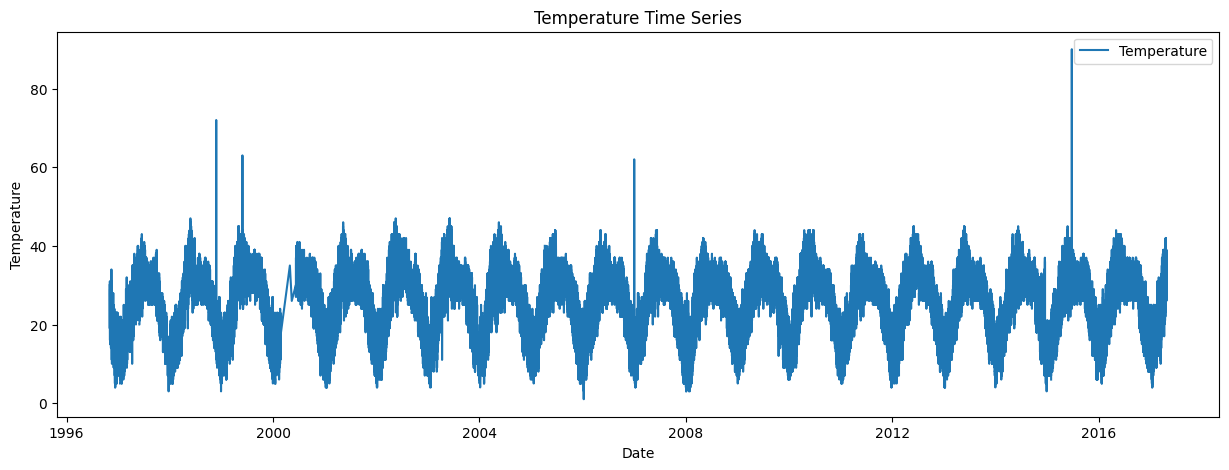

In [120]:
# Plot data
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temp'], label='Temperature')
plt.title('Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Resampling dan Imputasi Missing Values

In [121]:
# Resample data menjadi skala harian dan mengambil rata-rata
df_daily = df.resample('D').mean()
df.head()

,temp
date,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0


In [123]:
# Cek missing values
df_daily.isna().sum()

temp    144
dtype: int64

In [124]:
# Mengisi missing values dengan nilai rata-rata mingguan
df_daily['temp'].fillna(df_daily['temp'].mean(), inplace=True)

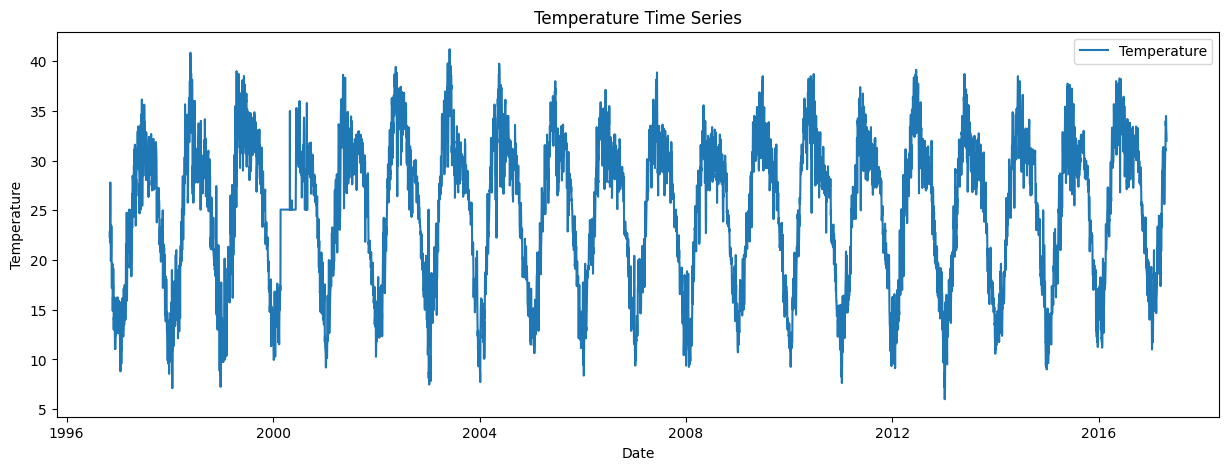

In [125]:
# Plot data
plt.figure(figsize=(15, 5))
plt.plot(df_daily.index, df_daily['temp'], label='Temperature')
plt.title('Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Normalisasi Data

In [126]:
scaler = MinMaxScaler()
temp_scaled = scaler.fit_transform(df_daily)

In [127]:
# Mempersiapkan data untuk model
temp_scaled = np.array(temp_scaled).reshape(-1)

In [128]:
temp_scaled

array([0.46387643, 0.48044345, 0.44849278, ..., 0.76397608, 0.76326607,
       0.73841555])

# Membagi Data Menjadi Training dan Validation Set

In [129]:
train_data, test_data = train_test_split(temp_scaled, test_size=0.2, shuffle=False)
train_data.shape, test_data.shape

((5984,), (1496,))

# Mempersiapkan Dataset Windowed

In [130]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

# Menetapkan parameter dataset
window_size = 60
batch_size = 32
shuffle_buffer = 1000

# Mempersiapkan dataset untuk training dan testing
train_set = windowed_dataset(train_data, window_size, batch_size, shuffle_buffer)
test_set = windowed_dataset(test_data, window_size, batch_size, shuffle_buffer)

# Membangun Model LSTM

In [131]:
# Membangun model LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

# Menggunakan optimizer dengan learning rate yang disesuaikan
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Melatih Model

In [132]:
# Callback untuk menghentikan training ketika sudah cukup baik
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(
    train_set,
    epochs=100,
    validation_data=test_set,
    callbacks=[callback]
)

Epoch 1/100
186/186 [==============================] - 9s 22ms/step - loss: 0.0055 - mae: 0.0719 - val_loss: 0.0021 - val_mae: 0.0511
Epoch 2/100
186/186 [==============================] - 3s 14ms/step - loss: 0.0024 - mae: 0.0539 - val_loss: 0.0019 - val_mae: 0.0489
Epoch 3/100
186/186 [==============================] - 3s 15ms/step - loss: 0.0021 - mae: 0.0497 - val_loss: 0.0017 - val_mae: 0.0449
Epoch 4/100
186/186 [==============================] - 3s 16ms/step - loss: 0.0018 - mae: 0.0459 - val_loss: 0.0013 - val_mae: 0.0403
Epoch 5/100
186/186 [==============================] - 4s 22ms/step - loss: 0.0015 - mae: 0.0420 - val_loss: 0.0014 - val_mae: 0.0409
Epoch 6/100
186/186 [==============================] - 3s 14ms/step - loss: 0.0013 - mae: 0.0390 - val_loss: 0.0010 - val_mae: 0.0352
Epoch 7/100
186/186 [==============================] - 3s 14ms/step - loss: 0.0013 - mae: 0.0376 - val_loss: 0.0011 - val_mae: 0.0347
Epoch 8/100
186/186 [==============================] - 3s 17ms

# Visualisasi Hasil Training

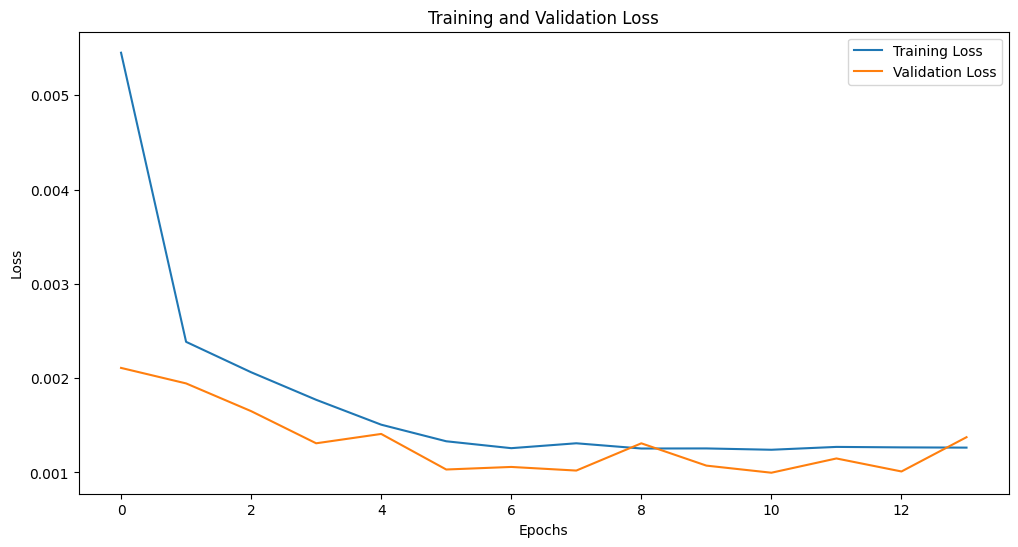

In [134]:
# Visualisasi Loss Training dan Validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluasi Model

In [137]:
# Evaluasi model pada data test
mae_test = model.evaluate(test_set)[1]

# Perhitungan threshold MAE
threshold_mae = (df_daily['temp'].max() - df_daily['temp'].min()) * 0.1

print(f"MAE pada data test: {mae_test}")
print(f"Threshold MAE (10% dari skala data): {threshold_mae}")

# Cek apakah MAE model < 10% skala data
if mae_test < threshold_mae:
    print("Model berhasil memenuhi kriteria MAE < 10% skala data.")
else:
    print("Model tidak memenuhi kriteria MAE < 10% skala data.")

45/45 [==============================] - 0s 7ms/step - loss: 0.0014 - mae: 0.0400
MAE pada data test: 0.039967816323041916
Threshold MAE (10% dari skala data): 3.5210526315789474
Model berhasil memenuhi kriteria MAE < 10% skala data.
